In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install ../input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
import talib as ta 

Processing /kaggle/input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl


In [4]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
import missingno as msno

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error


import statsmodels.api as sm
from pylab import rcParams

from tqdm import tqdm

# import ta
from talib import abstract


import time
import gc
import sys

# sys.path.insert(0, '../input/jpx-local-api')
# from local_api import local_api

In [5]:
data = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
# display(data)
train = data.copy()

# using supplement data as test data
supp_data = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')

# train_with_supp = pd.concat([train, supp_data]).reset_index(drop=True)
# train_with_supp = train.copy()
# train_with_supp


supplemental data 는 21/12/06 ~ 22/05/27까지 현재 115일로 이루어져 있다 (갱신될 수 있음)

In [6]:
supp_data.groupby('Date').count()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2021-12-06,2000,2000,1994,1994,1994,1994,2000,2000,0,2000,2000
2021-12-07,2000,2000,1996,1996,1996,1996,2000,2000,0,2000,2000
2021-12-08,2000,2000,1992,1992,1992,1992,2000,2000,0,2000,2000
2021-12-09,2000,2000,1994,1994,1994,1994,2000,2000,0,2000,2000
2021-12-10,2000,2000,1994,1994,1994,1994,2000,2000,0,2000,2000
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,1998,1998,1995,1995,1995,1995,1998,1998,0,1998,1998
2022-05-24,1998,1998,1989,1989,1989,1989,1998,1998,0,1998,1998
2022-05-25,1998,1998,1994,1994,1994,1994,1998,1998,0,1998,1997


In [8]:
# 2021-10-20 이후로 설정하는 이유에 대해 EDA로 알아보기.

# df = df[df.Date>"2021-10-20"]

In [9]:
def time_elapsed(t0):
    t1 = time.time()
    print(time.time() - t0)
    return t1

SecuritiesCode 에 따라 인덱싱하는 것이 시간 소요가 너무 크다.  
미리 Data를 종목마다 쪼개서 넣어 놓는게 좋겠다. - > 리스트 활용

In [10]:
def divideSecurities(df):
    sec_list = []
#     print('Divide securities individually..')
    for code in np.sort(df.SecuritiesCode.unique()):
        sec_list.append(df.loc[df.SecuritiesCode == code, :].reset_index(drop=True))
    return sec_list

sec_list = divideSecurities(train)

In [11]:
def add_features_train(input_df, sec_list):
    df_list = []
    for df in tqdm(sec_list):
        
        # shadows
        df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
        df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']
        

        
        # lagged features
        # 날짜 단위이므로 7일전, 30일전, 180일전, 360일전 
        # lagged close, target (target 은 정확히 무엇? return인가)
        
        # lagged feature 계산하기 전 결측치 채워넣기
        df = df.fillna(method='ffill')
        

        
        # TA-lib features - RSI, EMA 7-90
        df['RSI'] = ta.RSI(df['Close'])
        df['EMA7'] = ta.EMA(df['Close'], 7)
        df['EMA15'] = ta.EMA(df['Close'], 15)
        df['EMA30'] = ta.EMA(df['Close'], 30)
        df['EMA90'] = ta.EMA(df['Close'], 90)
        

        
#         for indicator in ta.get_function_groups()['Pattern Recognition']:
#             df[str(indicator)] = getattr(ta,str(indicator))(df.Open, df.High, df.Low, df.Close)


        # fill ema features by backward -- 이렇게 채워진 것은 false data 이므로 일단 test 해보고 없애는 것을 검토하자.
        df = df.fillna(method='bfill')

    
        # volatility
        
        df_list.append(df)

        
    df_feature_added = pd.concat(df_list).sort_values(['Date','SecuritiesCode'])
    
    return df_feature_added


In [12]:
# add feature to data

df_added = add_features_train(train, sec_list)
# df_added.to_csv('train_with_supp_feature_added.csv', index=False)

# load data
# df_added = pd.read_csv('/kaggle/input/train-with-supp-feature-added-v1-all-cdl/train_with_supp_feature_added.csv')

# df_added

100%|██████████| 2000/2000 [00:14<00:00, 134.62it/s]


In [13]:
df_added.Date.unique()

array(['2017-01-04', '2017-01-05', '2017-01-06', ..., '2021-12-01',
       '2021-12-02', '2021-12-03'], dtype=object)

In [14]:
# 1202 개의 시간 간격이 모든 상품에 대해서 존재하는지 알아보기. 

In [15]:
def add_features_infer(input_df, close_df): #input df 는 price 데이터
    
    df_list = []
    sec_list = divideSecurities(input_df)
    
    close_list = divideSecurities(close_df) # for rolling features
    
    for i in range(len(sec_list)):
        
        
        close = close_list[i] #.loc[close_df.SecuritiesCode == code, :].fillna(method='ffill')
        df = sec_list[i]
        
        # test data의 open, high, low, close 중 nan 있으면 이전 값에서 가져와 채움
        if df.loc[:, ['Open', 'High', 'Low', 'Close']].isna().any().any():
            df.loc[:, ['Open', 'High', 'Low', 'Close']] = close.loc[close['Date'] == close.iloc[-1]['Date'], ['Open', 'High', 'Low', 'Close']].values 
        
        # shadows
        df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
        df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']

        # lagged features
        # 날짜 단위이므로 7일전, 30일전, 180일전, 360일전 
        # lagged close, target (target 은 정확히 무엇? return인가)
        
        ## Rolling features ##
        # TA-lib features - RSI, EMA 7-90
        df['RSI'] = ta.RSI(close['Close']).iloc[-1]
        df['EMA7'] = ta.EMA(close['Close'], 7).iloc[-1]
        df['EMA15'] = ta.EMA(close['Close'], 15).iloc[-1]
        df['EMA30'] = ta.EMA(close['Close'], 30).iloc[-1]
        df['EMA90'] = ta.EMA(close['Close'], 90).iloc[-1]
        
        
#         for indicator in ta.get_function_groups()['Pattern Recognition']:
#             df[str(indicator)] = getattr(ta,str(indicator))(df.Open, df.High, df.Low, df.Close)


        # volatility
        
        df_list.append(df)
    
    df_feature_added = pd.concat(df_list)
    
    return df_feature_added



In [16]:
def preprocess_train(df):
    
    # remove columns - Date removed temporarily
    dfc = df.drop(columns=['RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'])
    
    
#     minmax = MinMaxScaler()
    stdsc = StandardScaler()
    ordinal = OrdinalEncoder()

    target = ['Target']
#     minmax_features = ['Date']
    ord_features = ['SecuritiesCode'] 
    scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow',
                      'RSI', 'EMA7', 'EMA15', 'EMA30', 'EMA90'] #+ [c for c in df.columns if c.startswith('CDL')] # pattern recognition features
    
#     date_scaled = minmax.fit_transform(dfc.loc[:,minmax_features])
    date_code_ord = ordinal.fit_transform(dfc.loc[:,ord_features])
    scaled = stdsc.fit_transform(dfc.loc[:,scaled_features])
    
#     display(pd.DataFrame(date_code_ord, columns=ord_features))
#     display(pd.DataFrame(scaled, columns=scaled_features))
    
    
    dfc_scaled = pd.concat([# pd.DataFrame(date_scaled, columns=minmax_features),
                            pd.DataFrame(date_code_ord, columns=ord_features),
                            pd.DataFrame(scaled, columns=scaled_features)], 
                            axis=1)
    dfc_scaled = pd.concat([df['Date'].reset_index(drop=True), dfc_scaled],
                           axis=1)
    dfc_scaled = dfc_scaled.set_index(['Date'])

    y = dfc.set_index(['Date']).loc[:, ['Target']]
    
    
    return dfc_scaled, y, [ordinal, stdsc]
    

X_scaled, y, trained_scalers = preprocess_train(df_added)  # 2021-12-06부터 test 시작이므로 그 전까지만 이용한다.

# X_scaled
y

,Target
Date,
2017-01-04,0.000730
2017-01-04,0.012324
2017-01-04,0.006154
2017-01-04,0.011053
2017-01-04,0.003026
...,...
2021-12-03,0.034816
2021-12-03,0.025478
2021-12-03,-0.004302


In [17]:
def preprocess_inference(df, trained_scalers: list):
    ordinal = trained_scalers[0]
    stdsc = trained_scalers[1]
    
      
    # remove columns - Date removed temporarily
    dfc = df.drop(columns=['RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'])
    
    
    target = ['Target']
    ord_features = ['SecuritiesCode'] 
    scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow',
                      'RSI', 'EMA7', 'EMA15', 'EMA30', 'EMA90'] #+ [c for c in df.columns if c.startswith('CDL')] # pattern recognition features
    
    
    date_code_ord = ordinal.transform(dfc.loc[:,ord_features])
    scaled = stdsc.transform(dfc.loc[:,scaled_features])
    dfc_scaled = pd.concat([pd.DataFrame(date_code_ord, columns=ord_features),
                            pd.DataFrame(scaled, columns=scaled_features)], axis=1)

    
    return dfc_scaled
    

# X_test_scaled = preprocess_train(df_added, trained_scalers)

# X_test_scaled

In [18]:
# base model - lgbm 
lgb = LGBMRegressor().fit(X_scaled, y)



## Configure test set and evaluate the model

use **TimeseriesCV**  
reference: [the notebook about time-series basics](https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

In [19]:
from sklearn.model_selection import TimeSeriesSplit 

Date당 주식(증권?) 수가 2000개에서 점점 줄어들어 마지막엔 1860개 정도 된다.

<AxesSubplot:>

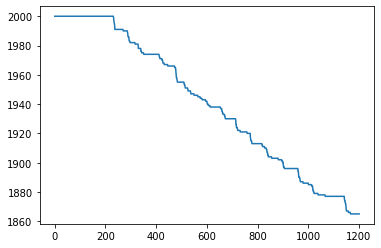

In [20]:
df_added.groupby(df_added.index).count().Date.plot()

train 의 전체 기간 1202일을 모두 커버하는 주식의 수는 1865개. 아닌 것이 135개이다.   

135개의 주식의 정보

In [21]:
train.groupby('SecuritiesCode').count().loc[train.groupby('SecuritiesCode').count().RowId != 1202, :]

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,,,,,,,,,,,
1375,297,297,296,296,296,296,297,297,3,297,297
1413,1149,1149,1148,1148,1148,1148,1149,1149,9,1149,1149
1431,602,602,601,601,601,601,602,602,10,602,602
1887,670,670,669,669,669,669,670,670,6,670,670
2932,293,293,292,292,292,292,293,293,2,293,293
...,...,...,...,...,...,...,...,...,...,...,...
9278,772,772,771,771,771,771,772,772,6,772,772
9279,759,759,758,758,758,758,759,759,7,759,759
9434,717,717,716,716,716,716,717,717,6,717,717


Time-series cv 를 어떻게 나누어야 할까?  


In [ ]:
X_scaled.columns

In [ ]:
X_scaled.loc[X_scaled.index.unique()[:10], :]

In [ ]:
X_scaled.index.unique()[:5]

In [ ]:
y

In [ ]:
grid[train_idx]

In [ ]:
# debugging
grid = X_scaled.index.unique()
tscv = TimeSeriesSplit(n_splits=10)
for train_idx, test_idx in tscv.split(grid):
    X_train = X_scaled.loc[grid[train_idx], :]
    y_train = y.loc[grid[train_idx], :]

### TimeseriesCV + Optuna 로 LGBM hyperparameter 튜닝하기

In [ ]:
def timeseriesCVerror(X, y, fold, loss, Model):#model, loss_function):
    errors = []
    tscv = TimeSeriesSplit(n_splits=fold)
    # split input : index date
    grid = X.index.unique()
    
    k = 0
    for train_idx, test_idx in tscv.split(grid):
        t0 = time.time()
        k += 1
        print(f'train for fold {k}...')
        
#         print(train_idx, test_idx)
#         print(grid[train_idx])
        X_train, y_train = X.loc[grid[train_idx], :], y.loc[grid[train_idx], :]
        X_test, y_test = X.loc[grid[test_idx], :], y.loc[grid[test_idx], :]
        
        mod = Model.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        errors.append(loss(y_pred, y_test))
        
        print(f'time elapsed for fold {k} : {time.time() - t0:.4f} s')
        
    print(errors)
    print(np.mean(errors))
    return

    
timeseriesCVerror(X_scaled, y, 10, mean_squared_error, 
                  LGBMRegressor(
                      num_leaves=4000, learning_rate=0.5, 
                      n_estimators=2500, max_bin=88,
                      seed=33
                      )
                 )

In [ ]:
?LGBMRegressor

In [ ]:
tscv = TimeSeriesSplit(n_splits=10) #약 120일로 test를 쪼개는 것이 supp_data와 비슷한 크기이므로 10으로 쪼갬.



In [ ]:
df_added.iloc[1749399:2040964]

evaluating metric : Sharpe ratio

### [Evaluation metric: Sharpe ratio](https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition) 로 점수 계산하기



In [22]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [34]:
# test : calculate sharpe ratio over train period 
# 결과로 Date, target, rank를 붙인 df를 반환한다.

eval_dates = supp_data['Date'].unique()  # supp 일자 리스트

predicted_df_list = []
for i, date in enumerate(tqdm(eval_dates)):
    prices = supp_data.loc[supp_data['Date'] == date]
    
    prediction = prices.loc[:, ["Date", "SecuritiesCode", "Target"]]
    
    

    today = prices.iloc[0]['Date']
    lastday = str(pd.to_datetime(today) - pd.DateOffset(140))

    if i == 0:
        close_df = pd.concat([
            train.loc[
                (train['Date'] > lastday) & (train['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)

    else:
        close_df = pd.concat([
            close_df.loc[
                (close_df['Date'] > lastday) & (close_df['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)


    feat = add_features_infer(prices, close_df)
    X = preprocess_inference(feat, trained_scalers)

    # X, y
    X['Target'] = lgb.predict(X)
    X['Rank'] = (X['Target'].rank(method='first', ascending=False)-1).astype(int)
    
    prediction['Rank'] = X['Rank'].values
    
    # check Rank
    assert prediction["Rank"].notna().all()
    assert prediction["Rank"].min() == 0
    assert prediction["Rank"].max() == len(prediction["Rank"]) - 1
    predicted_df_list.append(prediction)
    
predicted_df = pd.concat(predicted_df_list)
display(predicted_df)
print('evaluated score:', calc_spread_return_sharpe(predicted_df))

100%|██████████| 115/115 [29:33<00:00, 15.42s/it]


,Date,SecuritiesCode,Target,Rank
0,2021-12-06,1301,-0.003263,1609
1,2021-12-06,1332,-0.008993,387
2,2021-12-06,1333,-0.009963,1305
3,2021-12-06,1375,-0.015032,1976
4,2021-12-06,1376,0.002867,588
...,...,...,...,...
229953,2022-05-27,9990,0.003378,534
229954,2022-05-27,9991,-0.005995,1762
229955,2022-05-27,9993,0.009315,1692
229956,2022-05-27,9994,-0.013540,1905


evaluated score: 0.03931598023439549


In [32]:

# (df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:



1.186944364567993

In [ ]:
# test : calculate sharpe ratio over train period 
# 결과로 Date, target, rank를 붙인 df를 반환한다.

today = prices.iloc[0]['Date']
lastday = str(pd.to_datetime(today) - pd.DateOffset(140))

if i == 0:
    close_df = pd.concat([
        train_with_supp.loc[
            (train_with_supp['Date'] > lastday) & (train_with_supp['Date'] < today), 
                ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
            prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
        ]).reset_index(drop=True)

else:
    close_df = pd.concat([
        close_df.loc[
            (close_df['Date'] > lastday) & (close_df['Date'] < today), 
                ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
            prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
        ]).reset_index(drop=True)


feat = add_features_infer(prices, close_df)
X = preprocess_inference(feat, trained_scalers)

# X, y
X['Target'] = lgb.predict(X)
X['Rank'] = (X['Target'].rank(method='first', ascending=False)-1).astype(int)
sample_prediction['Rank'] = X['Rank'].values
# check Rank
assert sample_prediction["Rank"].notna().all()
assert sample_prediction["Rank"].min() == 0
assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1

In [ ]:
def timeseriesCVscore(params, model, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        predictions = model.predict[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
# del data, train, supp_data, y, X_scaled
# gc.collect()

In [ ]:
# # local-api
# myapi = local_api('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files')
# env = myapi.make_env()
# iter_test = env.iter_test()
# for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(tqdm(iter_test)):
# #     t0 = time.time()
    
#     # 이전 데이터와 합치고 최근 140일치만 이용한다
#     today = prices.iloc[0]['Date']
#     lastday = str(pd.to_datetime(today) - pd.DateOffset(140))
    
#     if i == 0:
#         close_df = pd.concat([
#             train_with_supp.loc[
#                 (train_with_supp['Date'] > lastday) & (train_with_supp['Date'] < today), 
#                     ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
#                 prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
#             ]).reset_index(drop=True)
        
#     else:
#         close_df = pd.concat([
#             close_df.loc[
#                 (close_df['Date'] > lastday) & (close_df['Date'] < today), 
#                     ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
#                 prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
#             ]).reset_index(drop=True)
        

#     feat = add_features_infer(prices, close_df)
#     X = preprocess_inference(feat, trained_scalers)

#     # X, y
#     X['Target'] = lgb.predict(X)
#     X['Rank'] = (X['Target'].rank(method='average', ascending=False)-1).astype(int)
#     sample_prediction['Rank'] = X['Rank'].values
    
#     # check Rank
#     assert sample_prediction["Rank"].notna().all()
#     assert sample_prediction["Rank"].min() == 0
#     assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
# #     display(sample_prediction)
#     env.predict(sample_prediction)
# #     print(time.time() - t0)

In [ ]:
# import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
# iter_test = env.iter_test()

pd.to_datetime 최소한도로 쓸것. 연산 cost가 너무 큼. 특히 inference 단계에서는 쓰지 않기.

In [ ]:
# 2000개 종목 리스트에서 날짜 하나씩 빼고 뒷날짜 추가 구현?


In [ ]:
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
#     t0 = time.time()
    
    # 이전 데이터와 합치고 최근 140일치만 이용한다
    today = prices.iloc[0]['Date']
    lastday = str(pd.to_datetime(today) - pd.DateOffset(140))
    
    if i == 0:
        close_df = pd.concat([
            train_with_supp.loc[
                (train_with_supp['Date'] > lastday) & (train_with_supp['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)
        
    else:
        close_df = pd.concat([
            close_df.loc[
                (close_df['Date'] > lastday) & (close_df['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)
        

    feat = add_features_infer(prices, close_df)
    X = preprocess_inference(feat, trained_scalers)

    # X, y
    X['Target'] = lgb.predict(X)
    X['Rank'] = (X['Target'].rank(method='first', ascending=False)-1).astype(int)
    sample_prediction['Rank'] = X['Rank'].values
    # check Rank
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
#     display(sample_prediction)
    env.predict(sample_prediction)
#     print(time.time() - t0)